<a href="https://colab.research.google.com/github/adityasengar/GNN_Pytorch_ESOL/blob/main/Graph_Neural_Nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Predicting Molecular Properties using GCN with PyTorch Geometric***


In [ ]:
!pip install rdkit-pypi torch torchvision torchaudio torch-geometric deepchem scikit-learn

In [ ]:
#Importing the relevant libraries

# torch: Core library for PyTorch, providing tensor operations and neural network functionalities.
# Used for creating and manipulating tensors, defining neural network models, and performing operations during training.
import torch

# torch.nn.functional (F): Module providing various functions commonly used in neural network operations.
# Used for applying activation functions, loss functions, and other operations on tensors.
import torch.nn.functional as F

# torch_geometric.data.DataLoader: Class for creating mini-batches of graph-structured data.
# Used for batching and shuffling graph data during training and testing.
from torch_geometric.data import DataLoader

# torch_geometric.nn.GCNConv: Graph convolutional layer specifically designed for graph neural networks (GNNs).
# Used for performing graph convolutions on node features and updating them by aggregating information from neighboring nodes.
from torch_geometric.nn import GCNConv

# torch_geometric.nn.global_add_pool: Function for global pooling operation on graph-structured data.
# Used for aggregating node-level features into a fixed-size graph-level representation by summing up the node features.
from torch_geometric.nn import global_add_pool

# sklearn.metrics.mean_squared_error: Function for calculating the mean squared error (MSE) between predicted values and ground truth labels.
# Used as a performance metric to evaluate the regression model's accuracy.
from sklearn.metrics import mean_squared_error

# torch_geometric.datasets.MoleculeNet: Class for loading the MoleculeNet dataset.
# Provides convenient access to benchmark datasets specifically designed for molecular machine learning tasks.
from torch_geometric.datasets import MoleculeNet

# matplotlib.pyplot (plt): Module for creating visualizations such as plots and graphs.
# Used for plotting histograms and molecule graphs for data analysis and visualization purposes.
import matplotlib.pyplot as plt

# numpy (np): Library providing efficient numerical computing functionalities.
# Used for handling arrays and mathematical operations.
import numpy as np


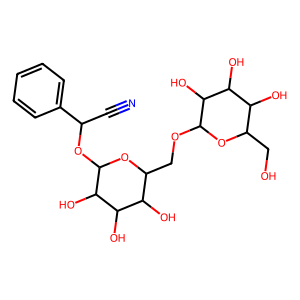

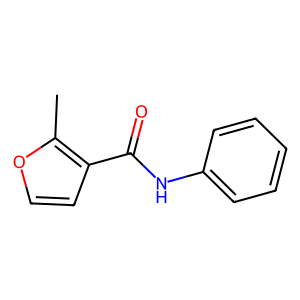

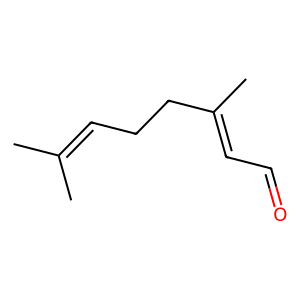

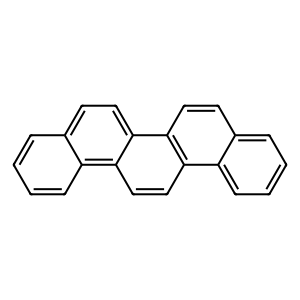

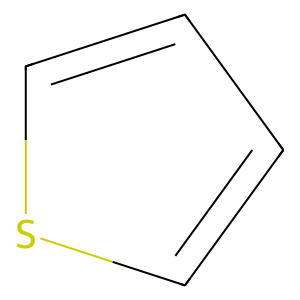

In [12]:
#Let's visualize some of the structures in our database

from rdkit import Chem
from rdkit.Chem import Draw

# Choose the indices of the molecules to visualize
molecule_indices = [0, 1, 2, 3, 4]

# Loop through the chosen molecule indices
for idx in molecule_indices:
    # Get the molecule data at the current index
    molecule_data = dataset[idx]

    # Extract the SMILES representation of the molecule
    smiles = molecule_data.smiles

    # Generate an RDKit molecule from the SMILES representation
    mol = Chem.MolFromSmiles(smiles)

    # Visualize the molecule
    img = Draw.MolToImage(mol)

    # Display the molecule image
    img.show()


Let's look at the water solubility distribution.

The water solubility graph visualizes the distribution of water solubility values in the ESOL dataset, which represents the ability of molecules to dissolve in water. By analyzing the graph, several insights can be gained:

**Distribution**: The histogram shows the frequency of different solubility levels, indicating if the dataset has a balanced distribution or if certain ranges are overrepresented or underrepresented.

**Central Tendency**: The histogram's shape reveals the central tendency of solubility values. A symmetric distribution concentrated around a specific value suggests a prominent central tendency in the dataset.

**Outliers**: The histogram identifies outliers or extreme solubility values, representing unique molecules with unusually high or low solubility compared to the majority.

**Data Range**: The range of solubility values provides an understanding of the span of solubility levels covered by the dataset, indicating the diversity of molecules in terms of their solubility characteristics.

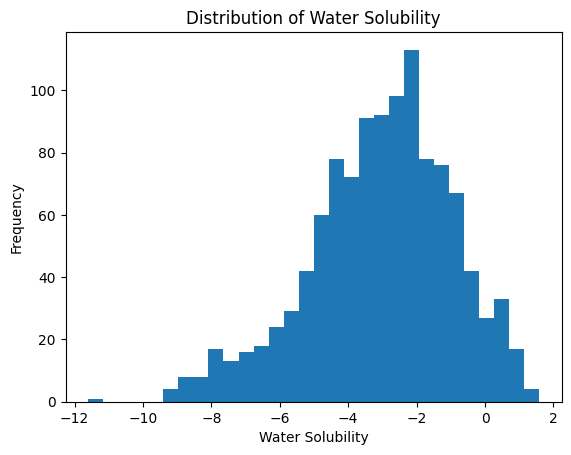

In [15]:
# Load the MoleculeNet dataset (ESOL in this case)
dataset = MoleculeNet(root='./data', name='ESOL')

# Extract the water solubility values from the dataset
solubility_values = dataset.data.y.numpy()

# Plot a histogram of the water solubility values
plt.hist(solubility_values, bins=30)
plt.xlabel('Water Solubility')
plt.ylabel('Frequency')
plt.title('Distribution of Water Solubility')
plt.show()


In [ ]:
# Define the Graph Convolutional Network (GCN) model
class GCN(torch.nn.Module):
    def __init__(self, num_features):
        super(GCN, self).__init__()

        # Define the graph convolutional layers
        self.conv1 = GCNConv(num_features, 16)  # First graph convolutional layer: input features -> 16 output features
        self.conv2 = GCNConv(16, 32)  # Second graph convolutional layer: 16 input features -> 32 output features
        self.conv3 = GCNConv(32, 1)  # Third graph convolutional layer: 32 input features -> 1 output feature

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Perform graph convolutions
        x = self.conv1(x.float(), edge_index.long())  # Apply the first graph convolutional layer
        x = F.relu(x)  # Apply ReLU activation
        x = self.conv2(x, edge_index.long())  # Apply the second graph convolutional layer
        x = F.relu(x)  # Apply ReLU activation
        x = self.conv3(x, edge_index.long())  # Apply the third graph convolutional layer

        # Global pooling
        x = global_add_pool(x, batch)  # Perform global pooling on the node representations

        return x.squeeze()  # Remove any singleton dimensions



# Define the training function
def train(model, loader, optimizer, device):
    model.train()

    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)


# Define the evaluation function
def evaluate(model, loader, device):
    model.eval()

    y_true = []
    y_pred = []
    for data in loader:
        data = data.to(device)
        output = model(data)
        y_true.append(data.y.cpu())
        y_pred.append(output.detach().cpu())

    y_true = torch.cat(y_true, dim=0).numpy()
    y_pred = torch.cat(y_pred, dim=0).numpy()

    rmse = mean_squared_error(y_true, y_pred, squared=False)

    return rmse


# Set the device to either 'cuda' or 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the MoleculeNet dataset (ESOL in this case)
dataset = MoleculeNet(root='./data', name='ESOL')

# Split the dataset into train and test sets
train_dataset = dataset[:800]
test_dataset = dataset[800:]

# Create train and test loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get the number of features from the dataset
num_features = dataset.num_features

# Create the model and move it to the device
model = GCN(num_features).to(device)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(1, num_epochs + 1):
    train_loss = train(model, train_loader, optimizer, device)
    test_rmse = evaluate(model, test_loader, device)
    print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Test RMSE: {test_rmse:.4f}')

